# Exercice : krigeage de la fonction Ishigami

On considère la fonction 
$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$
pour tout $X_1,X_2,X_3\in[-\pi,\pi]$ où $a=7$ et $b=0.1$. 

On suppose que les variables sont indépendantes et suivent la loi uniforme entre $-\pi$ et $\pi$.

L'objectif de cet exercice est de créer un métamodèle de krigeage de cette fonction. Puis nous allons réaliser l'étude de sensibilité de la fonction, en utilisant le métamodèle.

In [74]:
import openturns as ot

from math import pi,sin 

*Questions*

**Définition du modèle**
* Définir la fonction `g` associée à la fonction.

In [75]:
g = ot.SymbolicFunction( ["X1","X2","X3"],["sin(X1)+7*sin(X2)^2 + 0.1*X3^4*sin(X1)"])
g([0,0,0])


class=Point name=Unnamed dimension=1 values=[0]

* Définir la distribution `distribution` au vecteur aléatoire en entrée.

In [76]:
distributionList = [ot.Uniform(-pi, pi)] * 3
distribution = ot.ComposedDistribution(distributionList)


**Apprentissage**
* Créer un échantillon `X_train` de taille 20 en entrée du modèle et évaluer les sorties correspondantes `Y_train`. 

In [77]:
sampleSize_train = 20
X_train = distribution.getSample(sampleSize_train)
Y_train = g(X_train)

* Dessiner l'histogramme des sorties. 

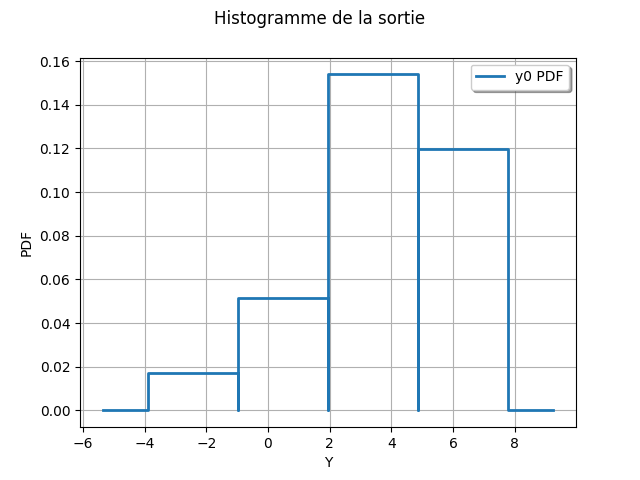

In [78]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Y")
histo.setTitle("Histogramme de la sortie")
histo

* Utiliser la classe `SquaredExponential` pour définir un modèle exponentiel carré. 

In [79]:
dimension = distribution.getDimension()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])


* Créer un métamodèle de krigeage avec la classe `KrigingAlgorithm`. Vous utiliserez une base de type `ConstantBasisFactory`.

In [80]:
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [12.2852,9.76079,11.1004]


**Validation**
* Créer un échantillon `X_test` de taille 100 en entrée du modèle et évaluer les sorties correspondantes `Y_test`. 

In [81]:
sampleSize_test = 100
X_test = distribution.getSample(sampleSize_test)
Y_test = g(X_test)

* Utiliser la classe `MetaModelValidation` pour valider le métamodèle. 

In [82]:
Y_test_MM = krigeageMM(X_test)

* Quel est la valeur du coefficient de prédictivité ? 

In [83]:
val = ot.MetaModelValidation(Y_test,Y_test_MM)


In [84]:
val.computePredictivityFactor()

WRN - computePredictivityFactor is deprecated


class=Point name=Unnamed dimension=1 values=[0.207071]

* La qualité est-elle suffisante pour utiliser le métamodèle ? Quels paramètres peut-on changer ?

je sais pas si suffisant car tout est outdated mais sinon on pourrait tenter avec un echantillon plus gros 

* Améliorez la qualité du métamodèle jusqu'à ce que la qualité soit suffisante, puis passez à la question suivante.

**Analyse de sensibilité**
* Utiliser la classe `SobolSimulationAlgorithm` pour estimer les indices de Sobol' du métamodèle. 

In [85]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True) # exemple de sobolsimulationalgorithme de openturns

In [86]:
algo = ot.SobolSimulationAlgorithm(distribution, krigeageMM, estimator)
algo.run()

* Afficher les indices de Sobol'. 

In [88]:
result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.0017084,0.589154,0.12249]
Total order = [0.00258277,0.87829,0.412235]


* Analyser les indices de Sobol' : identifier les variables les plus influentes et les interactions.

On a le l'indice de Sobol de X1 qui vaut 0.76 , pour X2 0.64 et pour X3 0.002 donc X1 et le plus influent suivant par X2 et X3 ne joue quasiment pas a lui tout seul, il existe via ses interactions.

Pour les interactions c'est encore X1 qui a le plus indices avec 0.35 indiquant que les interactions avec X1 influe en majorite sur le resultat de Y ,  X2  quand a lui a un indice de Sobol du premier ordre proche du total donc il interagit peu,  X3 a une vraiment très faible influence.

en refaisant tourner mon code les indices de sobol change 